In [1]:
import sys
sys.path.append('../')

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from maze.classifier import Classifier

In [2]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
PATH_TO_DATA = '../data/training'

In [3]:
# Define the image transformations: resize to the same size, convert to tensor, and normalize pixel values
transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),  # Random rotation
        #transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.2), ratio=(1.0, 1.0)),  # Randomly crop the image between 80% and 100% of its original size
        transforms.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),  # Pad the image if it is smaller than the desired size
        transforms.ToTensor(),  # Convert PIL Image to Torch Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet mean and standard deviation
])

# Create a dataset from your image folder
# This assumes that your image folder has two subfolders: 'fish' and 'background', each containing images of the corresponding class
dataset = datasets.ImageFolder(PATH_TO_DATA, transform=transform)

# Split your dataset into training and validation sets
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
batch_size = 32

# Create DataLoaders for the training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = Classifier()

model.to(device)

criterion = nn.BCELoss()

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Define your scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

# number of epochs to train the model
num_epochs = 200

Training:   0%|          | 0/200 [00:00<?, ?it/s]

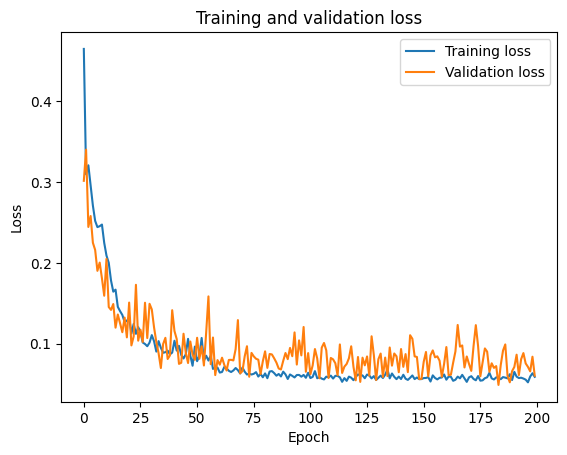

In [5]:
# Initialize lists to store losses for each epoch
train_losses = []
val_losses = []

pbar = tqdm(range(num_epochs), desc="Training")

for epoch in pbar:
    # Initialize variables to store the total loss in this epoch
    train_loss = 0.0
    val_loss = 0.0

    # Training loop
    model.train()  # Set the model to training mode
    for images, labels in train_loader:

        # Move the training data to the GPU
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float().view_as(outputs))
        loss.backward()
        optimizer.step()

        # Add this batch's loss to the total loss for this epoch
        train_loss += loss.item()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels.float().view_as(outputs))

            # Add this batch's loss to the total loss for this epoch
            val_loss += loss.item()

    # Divide the total loss by the number of batches to get the average loss for this epoch
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # Add the average losses for this epoch to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    pbar.set_description(f"Epoch {epoch+1}/{num_epochs}: train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")

    # Update the learning rate
    scheduler.step(val_loss)

# Plot the training and validation loss
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

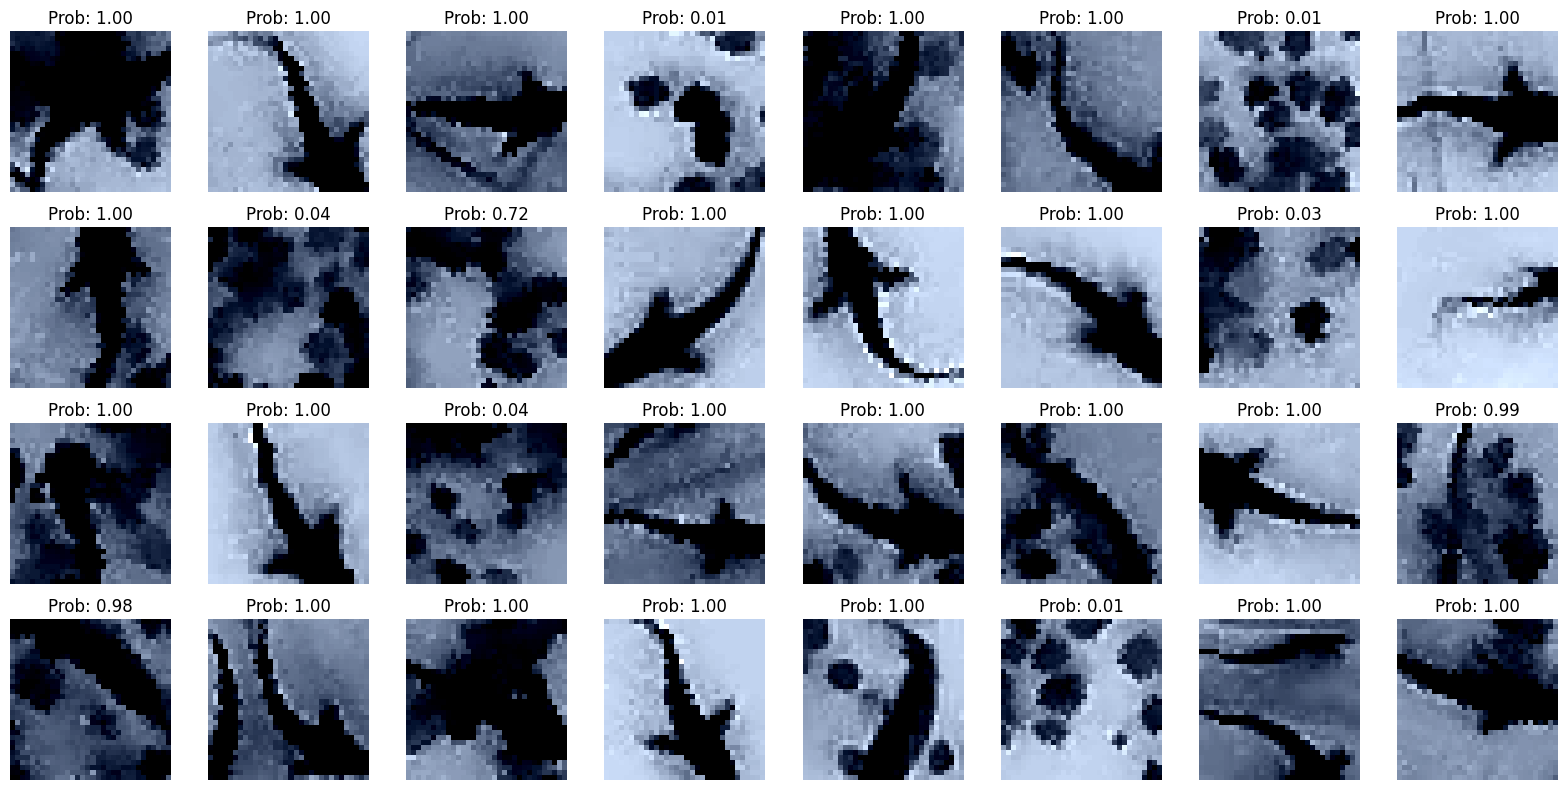

In [6]:
# display a grid of validation data using matplotlib
images, labels = next(iter(val_loader))

# shuffle images and labels
idx = torch.randperm(images.shape[0])
images = images[idx]
images = images[idx]

# take only 32 images
images = images[:32].to(device)
labels = labels[:32].to(device)

outputs = model(images)
outputs = outputs.squeeze(1).detach().cpu().numpy()  # Convert tensor to numpy array
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
for idx, image in enumerate(images):
    # renormalize the image to [0-1]
    image = image / 2 + 0.5

    ax = axes.flatten()[idx]
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(f"Prob: {outputs[idx]:.2f}")
    ax.set_axis_off()
plt.tight_layout()
plt.show()


In [7]:
# write the model to a file
torch.save(model, '../data/models/model_cnn4_v3.pth')